# Audio Signal Processing

This tests the ability to process audio signals using the linear systems tools avaiable in the python control systems library.  The background on audio i/o in Python comes from http://musicinformationretrieval.com/ipython_audio.html.

## Install some libraries

In [49]:
!pip install sounddevice

In [50]:
!pip install librosa

In [51]:
!pip install control

In [135]:
!pip install slycot

  Using cached slycot-0.2.0.tar.gz
  Running setup.py bdist_wheel for slycot ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

## Copy Sound Clips from a Library and Playback in a Jupyter Notebook

In [59]:
import urllib.request as urllib

urllib.urlretrieve(
    'http://audio.musicinformationretrieval.com/simpleLoop.wav', 
    filename='simpleLoop.wav'
)

urllib.urlretrieve(
    'https://ccrma.stanford.edu/workshops/mir2014/audio/CongaGroove-mono.wav', 
    filename='CongaGroove-mono.wav'
)

('CongaGroove-mono.wav', <http.client.HTTPMessage at 0x11a7a44e0>)

In [60]:
from IPython.display import Audio
Audio('simpleLoop.wav')

In [61]:
Audio('CongaGroove-mono.wav')

## Create a Sinusoidal Sound Clip of a Known Frequency

In [62]:
import numpy as np

T = 3         # length of clip
f = 440       # frequency in Hertz (cycles per second)
fs = 22050    # samples per second (standard CD is 44100)

t = np.linspace(0, T, int(T*fs), endpoint=False)
y = np.sin(2*np.pi*f*t)

Audio(y,rate=fs)

## Read a Sound Clip and Plot

66150
22050


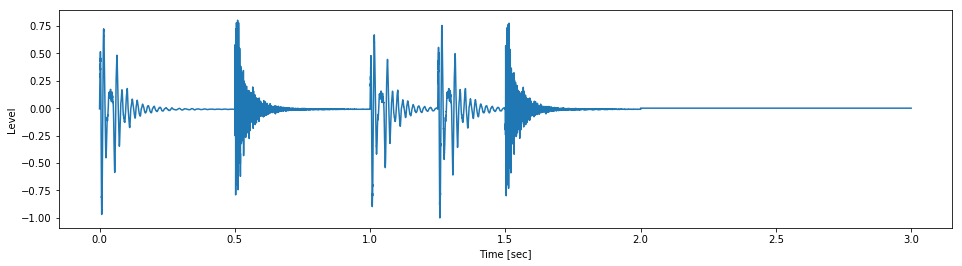

In [75]:
import librosa

x, fs = librosa.load('simpleLoop.wav')    # returns numpy array of samples, x, and sample rate fs
print(len(x))
print(fs)

T = len(x)/fs
t = np.linspace(0,T, int(T*fs),endpoint=False)

plt.figure(figsize=(16,4))
plt.plot(t,x)
plt.xlabel('Time [sec]')
plt.ylabel('Level')

In [67]:
Audio(x,rate=fs)

## Simulate the Effect of Transfer Functions on Sound Clips

Create a transfer function we'll call $G_d(s)$, create the Bode plot.

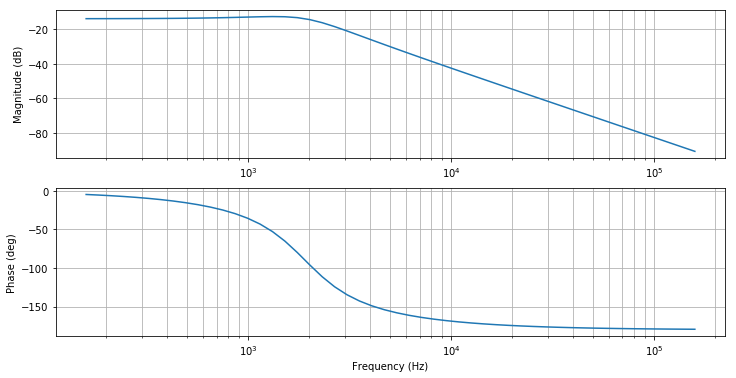

In [149]:
import control.matlab as control

tau = 1/12000      # fairly low cutoff frequency
zeta = 0.5       # damping factor

Gd = control.tf([0.2],[tau*tau, 2*zeta*tau, 1])

plt.figure(figsize=(12,6))
control.bode(Gd,Hz=True,dB=True);

# this will generate a warning that can be ignored
import warnings
warnings.filterwarnings('ignore')

Load a sound clip, and store as a numpy array x sampled at the times shown in t.

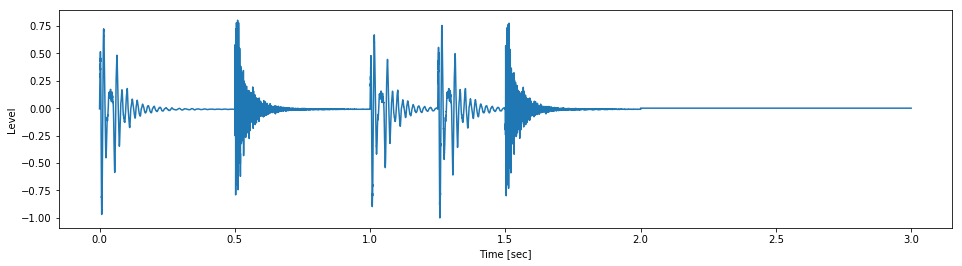

In [123]:
x, fs = librosa.load('simpleLoop.wav')    # returns numpy array of samples, x, and sample rate fs

T = len(x)/fs
t = np.linspace(0,T, int(T*fs),endpoint=False)

plt.figure(figsize=(16,4))
plt.plot(t,x)
plt.xlabel('Time [sec]')
plt.ylabel('Level')
Audio(x,rate=fs)

Now process the sound using the transfer function Gf, and plot the result.

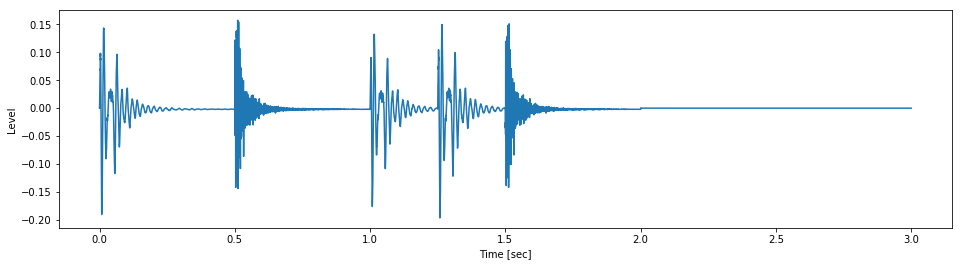

In [138]:
import control
t,yout,tmp = control.forced_response(Gd,t,x)     # this generates three outputs, the third one can be ignored.

plt.figure(figsize=(16,4))
plt.plot(t,yout)
plt.xlabel('Time [sec]')
plt.ylabel('Level')
Audio(yout,rate=fs)

## Create a Two Channel Input - Music + Background 

In [189]:
import librosa

music, fs_music = librosa.load('simpleLoop.wav')    # returns numpy array of samples, x, and sample rate fs
print(len(music))
print(fs_music)

noise, fs_noise = librosa.load('CongaGroove-mono.wav')    # returns numpy array of samples, x, and sample rate fs
print(len(noise))
print(fs_noise)

66150
22050
96213
22050


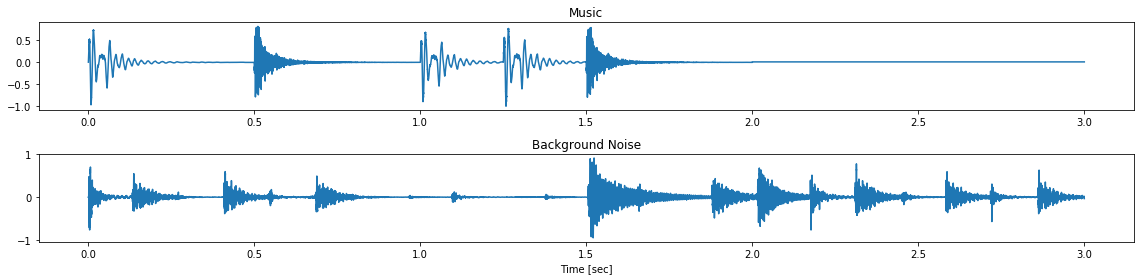

In [190]:
N = min(len(music),len(noise))
music = music[0:N]
noise = noise[0:N]
fs = fs_noise

T = N/fs
t = np.linspace(0,T,N,endpoint=False)

plt.figure(figsize=(16,4))
plt.subplot(2,1,1)
plt.plot(t,music)
plt.title('Music')

plt.subplot(2,1,2)
plt.plot(t,noise)
plt.title('Background Noise')
plt.xlabel('Time [sec]')

plt.tight_layout()

## Headphone performance without active feedback

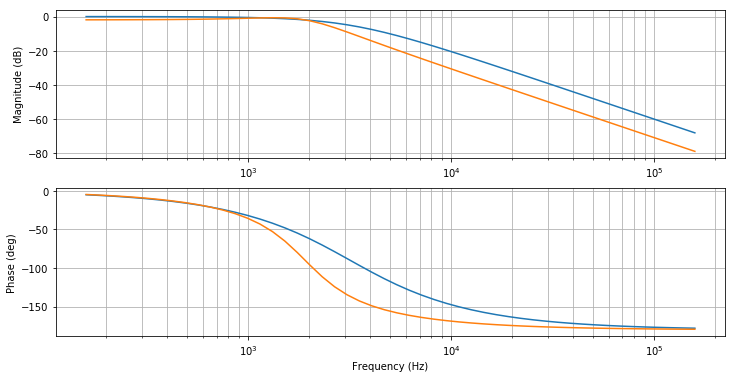

In [191]:
# speaker transfer function
tp = 1/20000
zetap = 0.9
Gs = control.tf([1],[tp*tp, 2*tp*zetap, 1])

# noise transfer function
tau = 1/12000      # fairly low cutoff frequency
zeta = 0.5       # damping factor
Gd = control.tf([0.8],[tau*tau, 2*zeta*tau, 1])

plt.figure(figsize=(12,6))
control.bode(Gs,Hz=True,dB=True);
control.bode(Gd,Hz=True,dB=True);

# this will generate a warning that can be ignored
import warnings
warnings.filterwarnings('ignore')

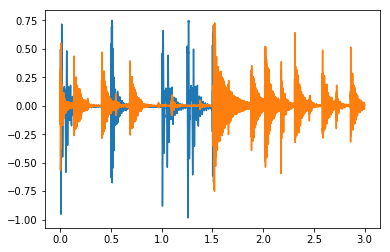

In [193]:
import control

t,yn,tmp = control.forced_response(Gd,t,noise)     # this generates three outputs, the third one can be ignored.
t,ym,tmp = control.forced_response(Gs,t,music)

plt.figure()
plt.plot(t,ym)
plt.plot(t,yn)

Audio(yn+ym,rate=fs)

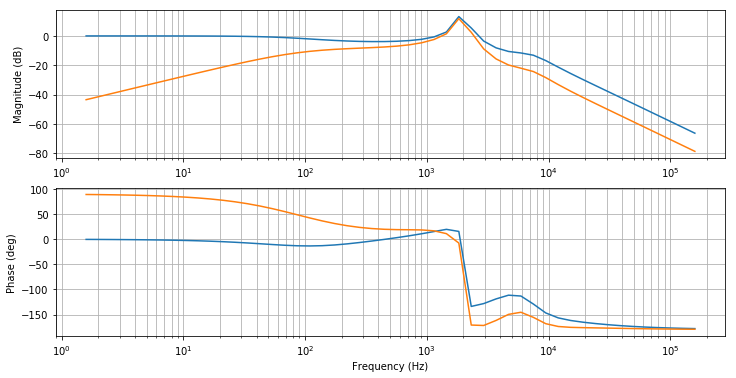

In [211]:
# microphone transfer function
tdelay = 0.000160  # 160 microsecond delay
num,den = control.pade(tdelay,3)
Gm = control.tf(num,den)

# control transfer function
ti = 1/1000
Gc = 1.2*control.tf([ti,1],[ti,0])

Hd = Gd/(1+Gs*Gc*Gm)
Hr = Gs*Gc/(1+Gs*Gc*Gm)

plt.figure(figsize=(12,6))
control.bode(Hr,Hz=True,dB=True);
control.bode(Hd,Hz=True,dB=True);

# this will generate a warning that can be ignored
import warnings
warnings.filterwarnings('ignore')

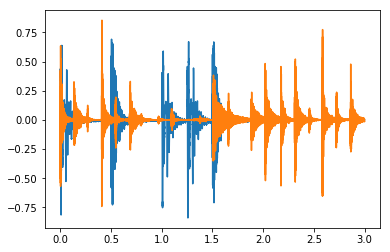

In [212]:
import control

t,yn,tmp = control.forced_response(Hd,t,noise)     # this generates three outputs, the third one can be ignored.
t,ym,tmp = control.forced_response(Hr,t,music)

plt.figure()
plt.plot(t,ym)
plt.plot(t,yn)

Audio(yn+ym,rate=fs)